In [288]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [289]:
rho_list, F_list = [], []

with open('data/FA_T_50_beta_eq.txt', 'r') as file:
    for line in file.readlines():
        #print(line, type(line), len(line))
        rho, F = float(line.split('\t')[0]), float(line.split('\t')[1].split('\n')[0]) 
        rho_list.append(rho)
        F_list.append(F)

rho = torch.tensor(rho_list) 
F = torch.tensor(F_list) / max(F_list)

n_skips = 1
rho = rho[::n_skips]
F = F[::n_skips]
print(rho.shape, F.shape)

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = rho
# True function is sin(2*pi*x) with Gaussian noise
train_y = F

torch.Size([200]) torch.Size([200])


In [290]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [291]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 20000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters
print([i for i in model.parameters()])

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

[Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor(0., requires_grad=True), Parameter containing:
tensor(0., requires_grad=True), Parameter containing:
tensor([[0.]], requires_grad=True)]
Iter 1/20000 - Loss: 0.763   lengthscale: 0.693   noise: 0.693
Iter 2/20000 - Loss: 0.744   lengthscale: 0.718   noise: 0.669
Iter 3/20000 - Loss: 0.725   lengthscale: 0.744   noise: 0.644
Iter 4/20000 - Loss: 0.706   lengthscale: 0.771   noise: 0.621
Iter 5/20000 - Loss: 0.687   lengthscale: 0.798   noise: 0.598
Iter 6/20000 - Loss: 0.667   lengthscale: 0.825   noise: 0.576
Iter 7/20000 - Loss: 0.648   lengthscale: 0.853   noise: 0.554
Iter 8/20000 - Loss: 0.628   lengthscale: 0.881   noise: 0.533
Iter 9/20000 - Loss: 0.608   lengthscale: 0.909   noise: 0.513
Iter 10/20000 - Loss: 0.588   lengthscale: 0.938   noise: 0.493
Iter 11/20000 - Loss: 0.567   lengthscale: 0.966   noise: 0.474
Iter 12/20000 - Loss: 0.547   lengthscale: 0.995   noise: 0.455
Iter 13/20000 - Lo

In [292]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 10)
    observed_pred = likelihood(model(test_x))

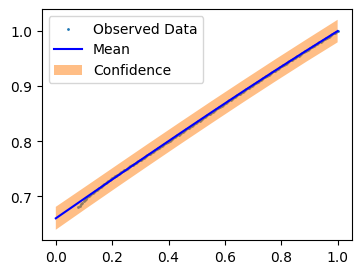

In [293]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.scatter(train_x.numpy(), train_y.numpy(), s=1)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])